## 96 well raw data growth experiment analysis


In [31]:
# import block
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import re
import os
from matplotlib_venn import venn3
import math
import sys
import multiprocessing as mp
from time import time, sleep
import openpyxl
import statistics
from scipy.stats import gompertz
from datetime import timedelta, datetime
import numpy as np
from scipy import stats
import tkinter as tk
from tkinter import ttk
from tkinter import filedialog as fd
from tkinter.messagebox import showinfo
from tkinter import filedialog
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc, dash_table
import dash_html_components as html
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
'''# google drive api

from __future__ import print_function

import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError'''




plt.rcParams['svg.fonttype'] = 'none'

<IPython.core.display.Javascript object>

# Raw data file parsing and virtual plate layout creation

In [32]:
#read raw data
''' We have a couple of different instrument so first I need to understand the file layout coming from each one
From a quick checkup it looks like the files are streaming out from the same software - Gen5 so int heory they should look the same unless the export promts are different.'''

# read file to count the lines to skip and lines to read. Also try to identify the column rang automatically

# ---------- get files from a shared folder on google drive - using drive desktop -----------

# read into a preprocess df
# store file names in a variable for easy use downstream
root = tk.Tk()
root.withdraw()
# this is for dev and debug purposes. IRL the files will be grabbed from a google drive folder
ipath='G:/Shared drives/Cultivarium/Culture/Data analysis results/'
showinfo('Plate results', 'Please choose the experiments results file')

filepath = filedialog.askopenfilename(initialdir=ipath)

# get the file name and get rid of the extension
filename=filepath.replace(ipath,'')

filename=filename.split('.')
filename=filename[0]

# create the results and inside create the graphics folder
respath=ipath+'/results_'+filename
if not os.path.isdir(respath):
    os.mkdir(respath)
graphicspath=respath+'/graphics'
if not os.path.isdir(graphicspath):
    os.mkdir(graphicspath)


# read in layout file and parse it
# note: add filename to all saved files
showinfo('Plate layout', 'Please choose the plate layout file')
layoutfile = filedialog.askopenfilename(initialdir=ipath)
# deal with multiple blanks and condition titles
samples={}
col2sample={}
blanks={}
conditions={}
def get_wells(wgstr, sampledict):
    wstr=wgstr.split('\t')
    sample=wstr[0]
    triplicates=wstr[1].split(',')
    triplicates=[s.strip() for s in triplicates]
    sampledict[sample]=triplicates
    for t in triplicates:
        col2sample[t]=sample
    
bflag=False
sflag=False
with open(layoutfile) as lin:
    for line in lin:
        line=line.replace('"','')
        if 'blanks' in line:
            bflag=True
            continue
        if '///' not in line and bflag:
            if '\\\\\\' in line:
                bflag=False
                continue
            get_wells(line,blanks)
        if 'samples' in line:
            sflag=True
            bflag=False
            continue
        if '///' not in line and sflag:
            if '\\\\\\' in line:
                sflag=False
                continue
            get_wells(line,samples)
        if 'conditions' in line:
            sflag= False
            bflag=False
            continue
        if '///' not in line and not (bflag or sflag):
            line=line.split('\t')
            if '\\\\\\' in line[0]:
                continue
            conditions[line[0].strip()]=line[1].strip()




ppdf=pd.read_excel(filepath)
cols=ppdf.columns
#print(cols[0])
# get the plate id, this will be the connector identifier between the plate and plate sample annotation files
plateidobj=ppdf[ppdf[cols[0]]=='Plate Number']
plateid=plateidobj.iloc[0,1]
print('Plate ID is: '+plateid)
# Get the line number of the 315,415 string
# start line number
sln=ppdf.index[ppdf[cols[0]]==315415]
#print(sln[0])
# get the end line number
eln=ppdf.index[ppdf[cols[0]]=='Results']
#print(eln[0])
nr=(eln[0]-sln[0])-4
#print(nr)
# starting from the synergy H1 format
expdf=pd.read_excel(filepath, skiprows=sln[0]+3, nrows=nr, usecols="B:CU")
#platedf.to_csv('test_input.csv')

# add a minutes column for easy plotting and calculations
minuteslist=[]
for t in expdf['Time']:
    t0=expdf.loc[0]['Time']
    hrs=t.hour
    minutes=t.minute
    seconds=t.second
    # calculate minutes
    tminutes=(hrs*60)+minutes+seconds/60
    minuteslist.append(tminutes)
    
# add the column to grapdf
minuteseries=pd.Series(minuteslist, name='total_minutes')
expdf=pd.concat([expdf,minuteseries],axis=1)

expdf


Plate ID is: Plate 1


Time  T° 315,415       A1       A2       A3   A4   A5   A6   A7   A8  \
0    00:00:00        23.0   179373   182665   177223  789  805  775  905  784   
1    00:01:10        23.0   209379   203760   200402  766  851  825  843  838   
2    00:02:20        23.0   240475   230881   226856  766  807  801  855  817   
3    00:03:30        23.0   270592   258045   258681  750  827  812  833  752   
4    00:04:40        23.0   297842   285681   282977  837  854  803  846  783   
..        ...         ...      ...      ...      ...  ...  ...  ...  ...  ...   
150  02:55:00        25.1  1206378  1200328  1203306  745  796  846  817  774   
151  02:56:10        25.1  1209057  1197400  1199231  743  760  798  781  750   
152  02:57:20        25.1  1203533  1200414  1198821  682  836  796  809  767   
153  02:58:30        25.1  1201578  1194486  1203895  803  779  862  768  764   
154  02:59:40        25.1  1203553  1198968  1197499  760  803  796  785  754   

     ...   H4   H5   H6   H7   H8   H9  H10  H11  H12  total_minutes  
0    ...  825  834  862  918  795  770  837  840  873       0.000000  
1    ...  885  807  855  807  831  759  852  784  866       1.166667  
2    ...  802  858  841  858  833  807  823  767  800       2.333333  
3    ...  828  794  840  851  823  783  860  789  755       3.500000  
4    ...  849  799  818  892  834  828  862  792  768       4.666667  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...            ...  
150  ...  820  800  825  811  755  781  855  761  768     175.000000  
151  ...  811  790  798  791  749  736  806  766  750     176.166667  
152  ...  772  838  848  817  785  705  767  749  786     177.333333  
153  ...  824  787  800  859  826  809  762  771  758     178.500000  
154  ...  787  793  809  778  758  775  787  799  834     179.666667  

[155 rows x 99 columns]

# Plate raw data overview

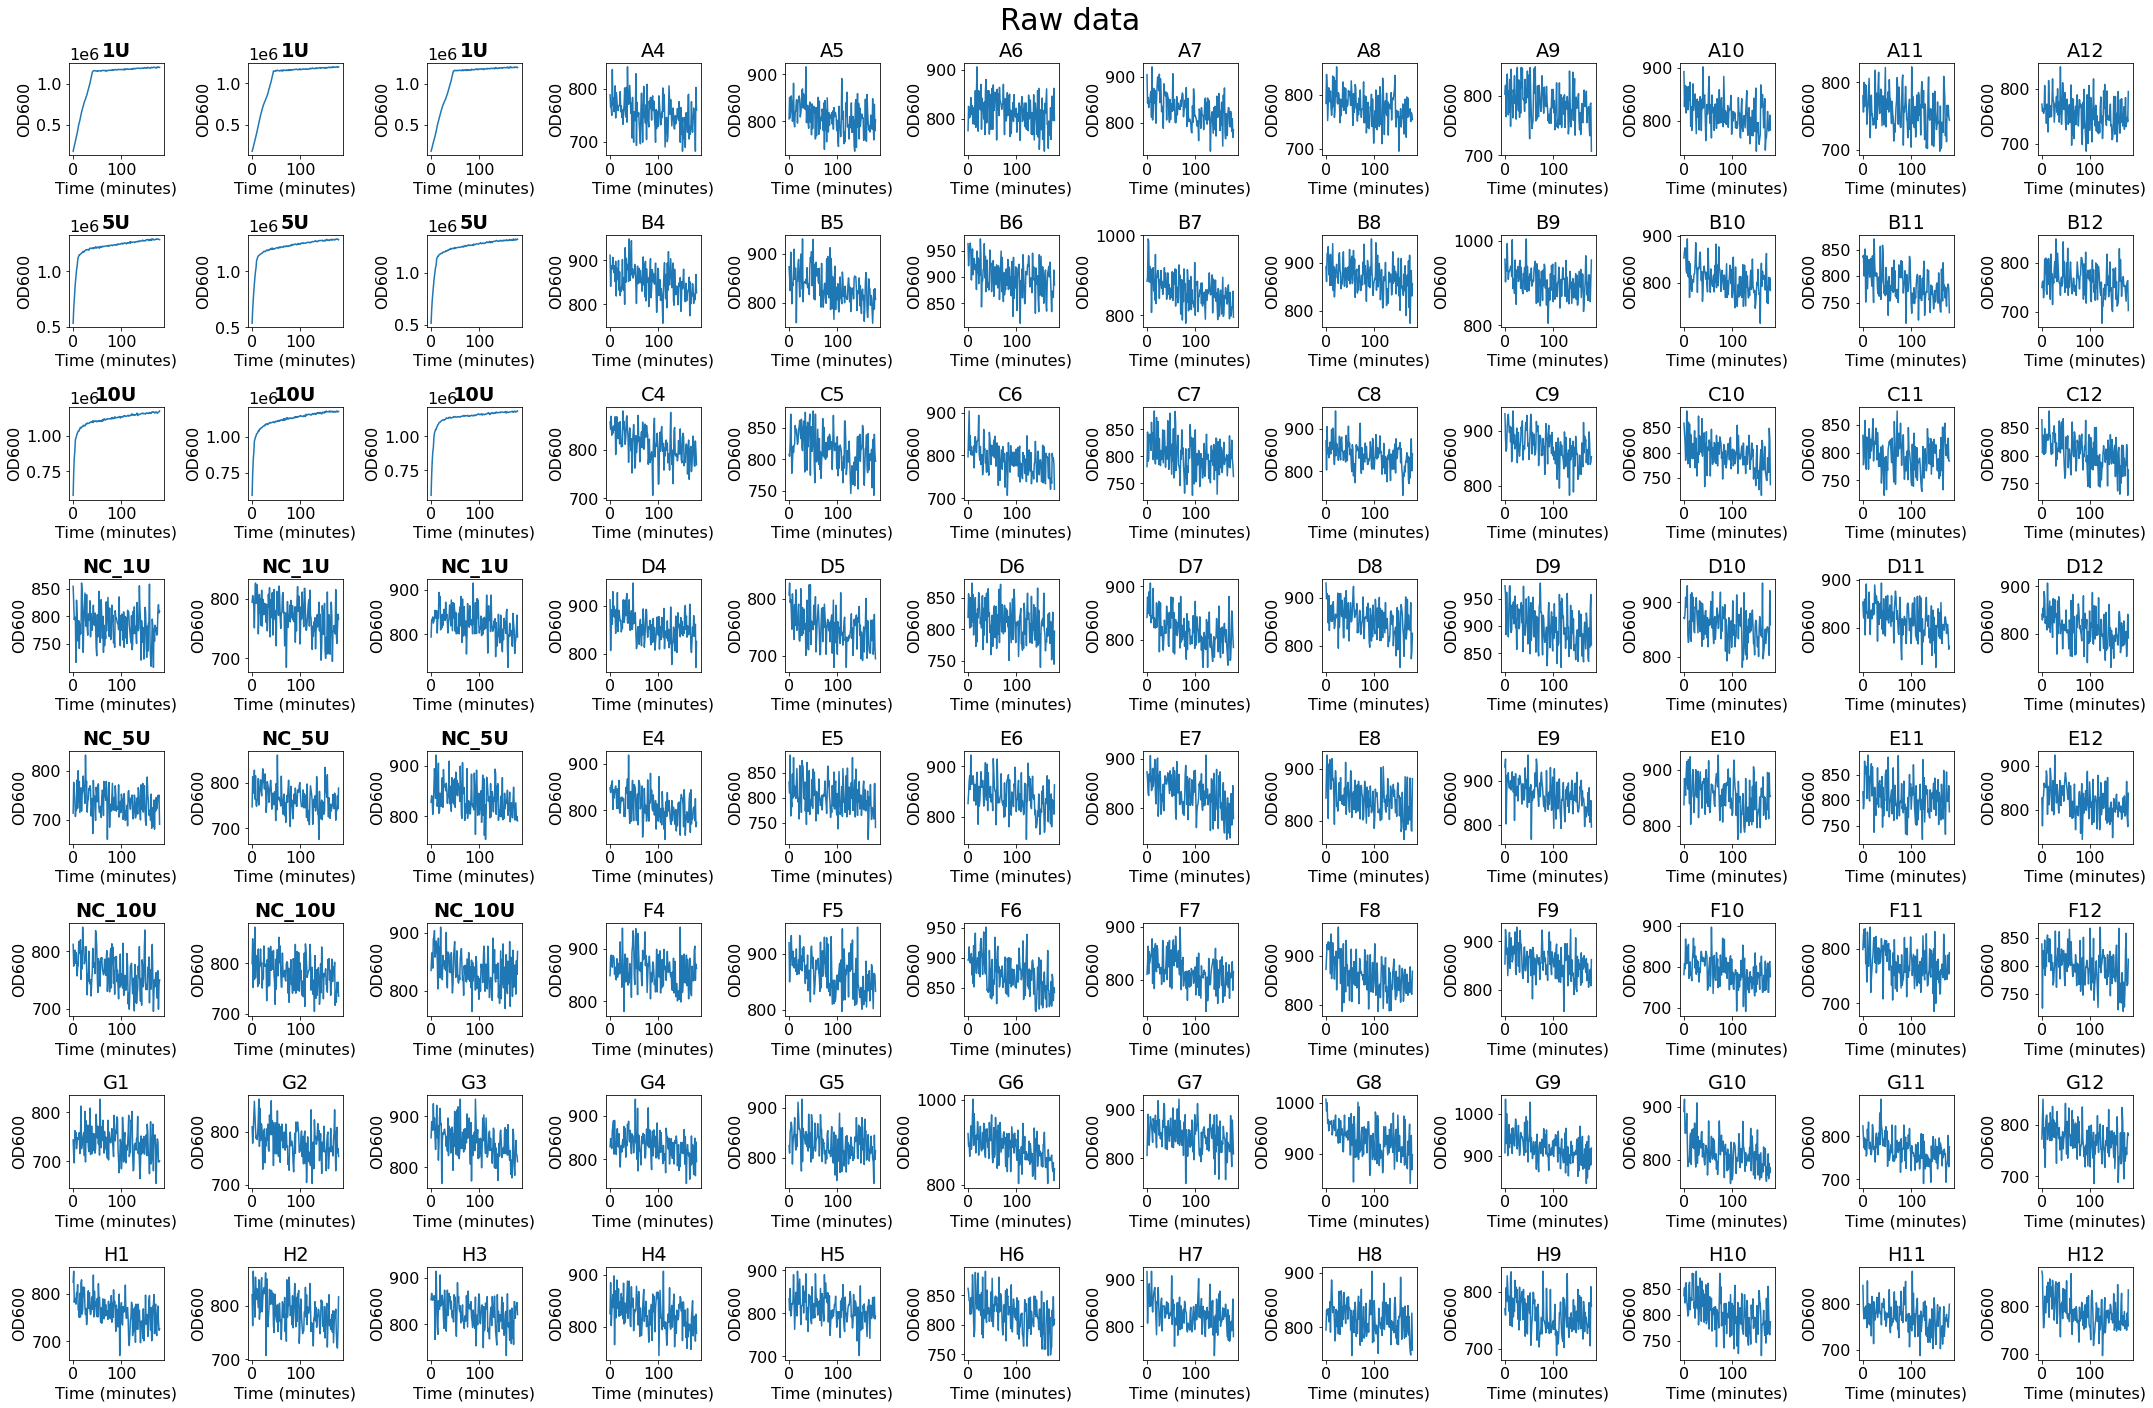

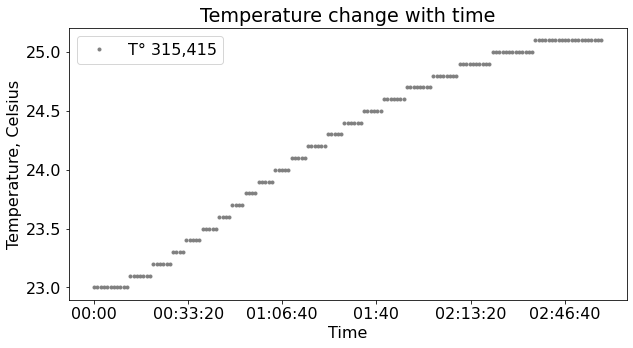

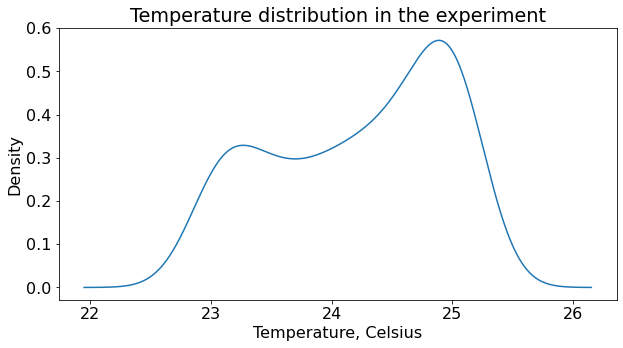

In [33]:
# general plots

# plot all the wells in subplots to look like the plate
def plotPlate(plate, title):
    
    # plots multiple subplots of  a given dataframe
    i=0
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    for col in plate.columns:
        if any(x in col for x in['Time','T° 315,415','total_minutes']):
            continue  
        w=re.match("([A-Z])([0-9]+)",col)
        nrows.add(w.group(1))
        ncols.add(w.group(2))
    fig=plt.figure(figsize=(2.5*len(ncols),2.5*len(nrows)))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Add the main title
    fig.suptitle(title, fontsize=30)
    for col in plate.columns:
        # skip the time and temperature column
        if any(x in col for x in['Time','T° 315,415','total_minutes']):
            continue    
        # go down a row every 12 wells
        i+=1
        '''if i%12==0:
            i=1'''
        ax=fig.add_subplot(len(nrows),len(ncols),i)
        ax.plot(plate['total_minutes'], plate[col])
        if col in col2sample:
            plt.title(col2sample[col],fontweight="bold")
        else:
            plt.title(col)
        plt.xlabel('Time (minutes)')
        plt.ylabel('OD600')
    plt.tight_layout()
    plt.savefig(graphicspath+'/'+title+'_'+filename +'.svg')
    plt.show()

plotPlate(expdf,'Raw data')       

# temperature distribution across time
cnames=expdf.columns

expdf.plot(x=cnames[0], y=cnames[1], figsize=(10,5), color='grey',style=".")
plt.title('Temperature change with time')
plt.ylabel('Temperature, Celsius')
plt.savefig(graphicspath+'/tempvstime_'+filename+'.svg')
plt.show()

plt.figure()
expdf[cnames[1]].plot.kde(figsize=(10,5), title='Temperature distribution in the experiment')
plt.xlabel('Temperature, Celsius')
plt.savefig(graphicspath+'/temp_dist_'+filename+'.svg')
plt.show()



# Blank subtraction
After reading the plate, identify samples by loading a sample file

155it [00:00, 1922.57it/s]


<Figure size 432x288 with 0 Axes>

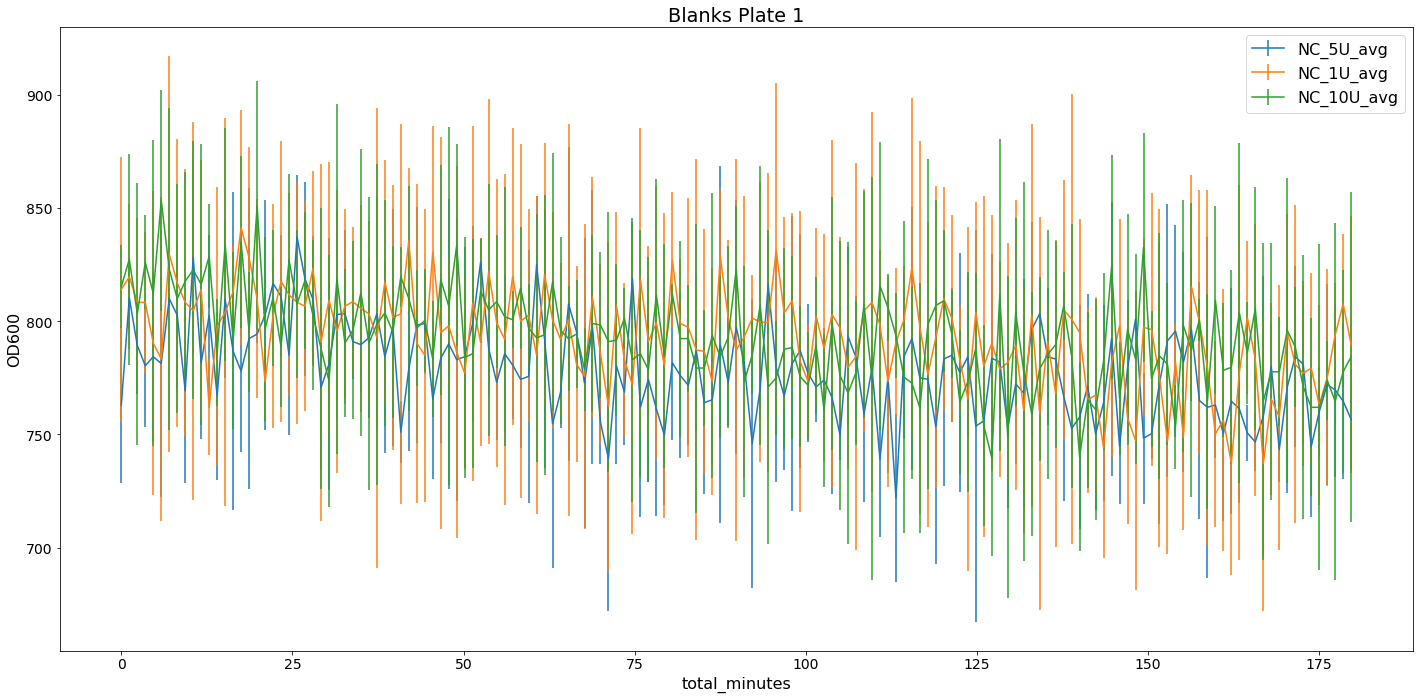

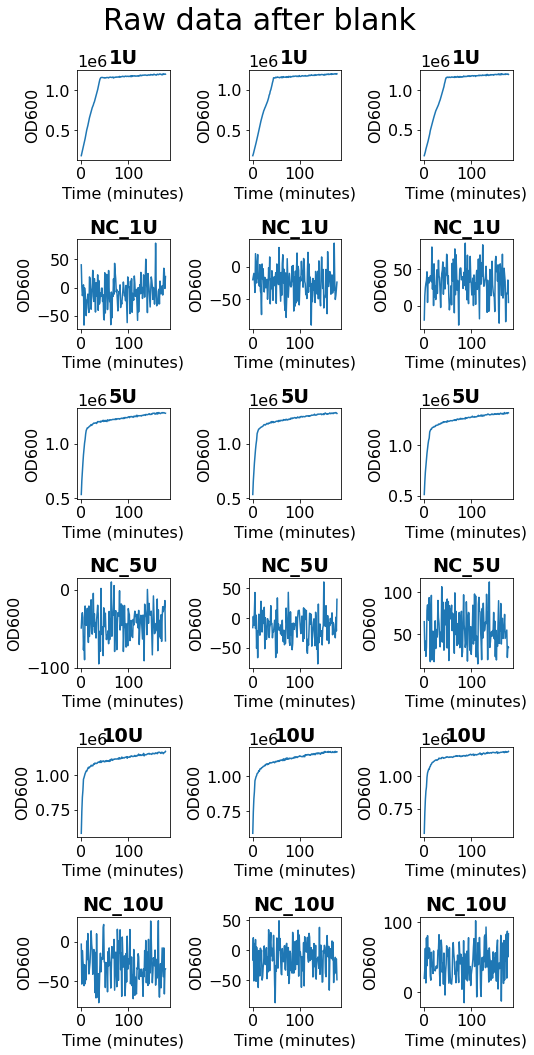

<Figure size 432x288 with 0 Axes>

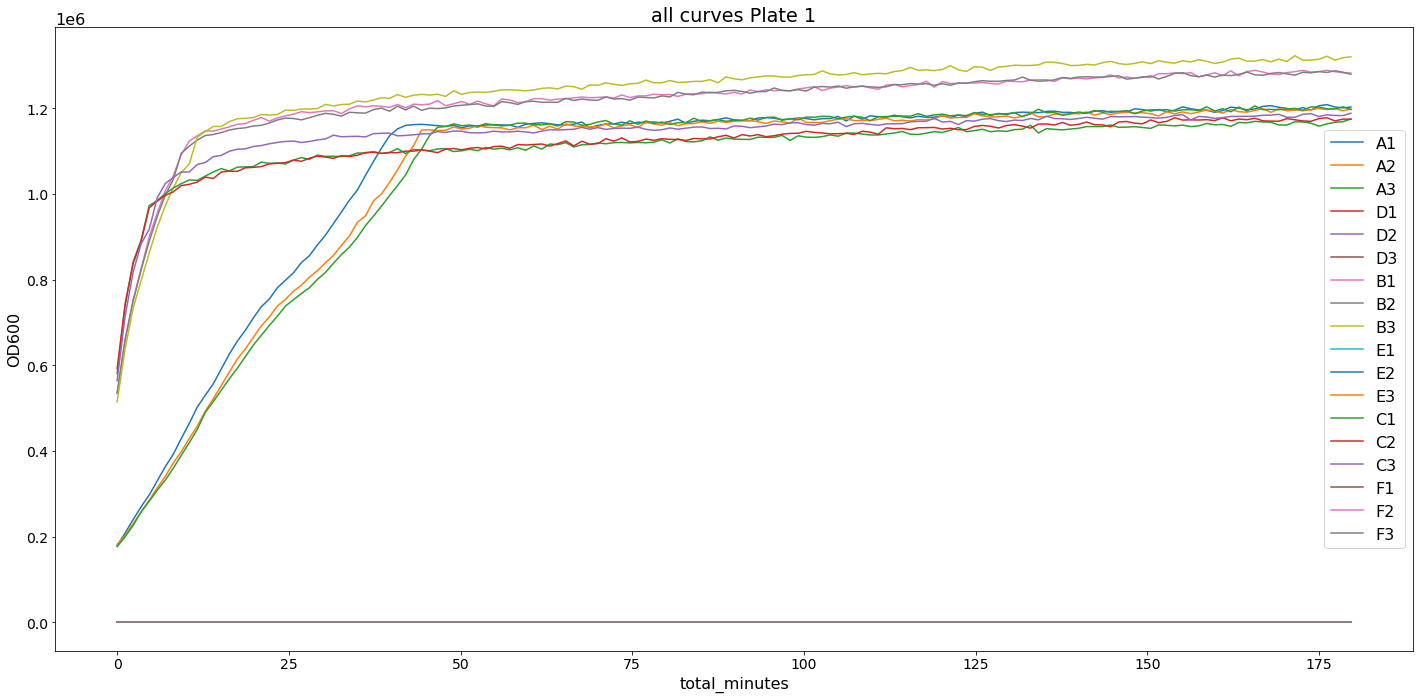

total_minutes            A1            A2            A3         D1  \
0         0.000000  1.785590e+05  1.818510e+05  1.764090e+05  40.000000   
1         1.166667  2.085593e+05  2.029403e+05  1.995823e+05   1.333333   
2         2.333333  2.396667e+05  2.300727e+05  2.260477e+05 -14.333333   
3         3.500000  2.697837e+05  2.572367e+05  2.578727e+05  -9.333333   
4         4.666667  2.970517e+05  2.848907e+05  2.821867e+05   4.666667   
..             ...           ...           ...           ...        ...   
150     175.000000  1.205615e+06  1.199565e+06  1.202543e+06   5.000000   
151     176.166667  1.208282e+06  1.196625e+06  1.198456e+06  34.000000   
152     177.333333  1.202739e+06  1.199620e+06  1.198027e+06  27.000000   
153     178.500000  1.200770e+06  1.193678e+06  1.203087e+06  -1.666667   
154     179.666667  1.202763e+06  1.198178e+06  1.196709e+06  19.333333   

            D2         D3            B1            B2            B3  \
0   -20.000000 -20.000000  5.343440e+05  5.352550e+05  5.144930e+05   
1   -14.666667  13.333333  6.617977e+05  6.588967e+05  6.385777e+05   
2   -10.333333  24.666667  7.528187e+05  7.495857e+05  7.331277e+05   
3   -21.333333  30.666667  8.264297e+05  8.230997e+05  7.981617e+05   
4   -39.333333  34.666667  8.992557e+05  8.889527e+05  8.616877e+05   
..         ...        ...           ...           ...           ...   
150 -22.000000  17.000000  1.285383e+06  1.285312e+06  1.314036e+06   
151 -50.000000  16.000000  1.288343e+06  1.283341e+06  1.321177e+06   
152 -44.000000  17.000000  1.285236e+06  1.287306e+06  1.312084e+06   
153 -33.666667  35.333333  1.282829e+06  1.283963e+06  1.317630e+06   
154 -23.666667   4.333333  1.281916e+06  1.279066e+06  1.319986e+06   

            E1         E2         E3            C1            C2  \
0   -49.000000 -16.000000  65.000000  5.802617e+05  5.918907e+05   
1   -33.333333   2.666667  30.666667  7.392327e+05  7.441117e+05   
2   -29.333333 -12.333333  41.666667  8.416647e+05  8.375957e+05   
3   -35.333333  11.666667  23.666667  8.925060e+05  8.896150e+05   
4   -77.333333  42.666667  34.666667  9.724577e+05  9.674617e+05   
..         ...        ...        ...           ...           ...   
150 -28.000000 -23.000000  51.000000  1.157928e+06  1.175674e+06   
151 -22.000000 -33.000000  55.000000  1.163328e+06  1.177615e+06   
152 -23.666667   1.333333  22.333333  1.166909e+06  1.170292e+06   
153 -13.666667 -21.666667  35.333333  1.168488e+06  1.174399e+06   
154 -65.666667  31.333333  34.333333  1.174942e+06  1.174233e+06   

               C3         F1         F2         F3  
0    5.637077e+05  -3.333333 -16.333333  19.666667  
1    7.149527e+05 -53.333333  20.666667  32.666667  
2    8.173987e+05 -11.333333 -51.333333  62.666667  
3    8.834190e+05 -24.000000  11.000000  13.000000  
4    9.171027e+05 -33.333333 -44.333333  77.666667  
..            ...        ...        ...        ...  
150  1.180381e+06 -44.000000 -39.000000  83.000000  
151  1.184452e+06  -8.000000 -12.000000  20.000000  
152  1.182951e+06 -65.666667 -21.666667  87.333333  
153  1.182832e+06 -35.666667 -14.666667  50.333333  
154  1.188140e+06 -34.333333 -49.333333  83.666667  

[155 rows x 19 columns]

In [34]:
# subtract blanks
# this will have the output table
workdf = pd.DataFrame()
cleandf=pd.DataFrame()
wd={}
cdict={}
nc_err_names=[]
nc_avg_names=set()
ncdict = {}
blank2samples={}
# ---------------analyze plate---------------------------

# plot all the wells in both semilog (y) and regular plots

for i, tp in tqdm(expdf.iterrows()):
    ncdict[tp['total_minutes']] = {}
    wd[tp['total_minutes']]={}
    cdict[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # blanks
    for b in blanks:
        curcols=[]
        vals=[]
        for nc in blanks[b]:
            vals.append(tp[nc])
        nc_avg=statistics.mean(vals)
        nc_stdev=statistics.stdev(vals)
        nca_name = b+'_avg'
        ncs_name = b+'_stdev'
        ncdict[tp['total_minutes']][nca_name] = nc_avg
        ncdict[tp['total_minutes']][ncs_name] = nc_stdev
        nc_err_names.append(ncs_name)
        nc_avg_names.add(nca_name)
        
        # find the columns matching the blank, the blanks are named NC_sample
        bsample=b.split('_')
        cursample=bsample[1].strip()
        # get the column list for the matching sample
        curcols=samples[cursample]
        blank2samples[b]=curcols
        
        # create a clean version for column selecting
        for ccol in curcols:
            #ccol_name = ccol+'_mb'
            cdict[tp['total_minutes']][ccol] =tp[ccol]-nc_avg
        # add the blank columns
        curcols=curcols+blanks[b]
        
        
        
        # subtract the blank average from each column value and keep in a new table
        
        for ccol in curcols:
            
            
            #ccol_name = ccol+'_mb'
            wd[tp['total_minutes']][ccol] =tp[ccol]-nc_avg

ncdf = pd.DataFrame.from_dict(ncdict, orient='index')
ncdf.index=ncdf.index.set_names(['total_minutes'])
ncdf.reset_index(inplace=True)

# get the new plate after subtracting the blanks - blank wells should show zero values
workdf = pd.DataFrame.from_dict(wd, orient='index')
workdf.index=workdf.index.set_names(['total_minutes'])
workdf.reset_index(inplace=True)

cleandf = pd.DataFrame.from_dict(cdict, orient='index')
cleandf.index=cleandf.index.set_names(['total_minutes'])
cleandf.reset_index(inplace=True)
# plot the blanks for a closer look


plt.figure()
plt.rcParams.update({'font.size': 16}) 
ncdf.plot(x='total_minutes',  y=list(nc_avg_names),yerr=ncdf[nc_err_names].T.values,
             figsize=(20,10),
             ylabel='OD600',
             title='Blanks '+plateid,
             #logy=True,
             fontsize=14,
             #color=colors
             )
plt.legend()
plt.tight_layout()
plt.savefig(graphicspath+'/blanks'+filename+'.svg')
plt.show()


# plot the samples after blank subtraction
plotPlate(workdf,'Raw data after blank')  


#plot all the curves on the same axis set
plt.figure()
plt.rcParams.update({'font.size': 16}) 
workdf.plot(x='total_minutes',
             figsize=(20,10),
             ylabel='OD600',
             title='all curves '+plateid,
             #logy=True,
             fontsize=14,
             #color=colors
             )
plt.legend()
plt.tight_layout()
plt.savefig(graphicspath+'/all_wells_after_blank'+filename+'.svg')
plt.show()
workdf


# Add log2 values 

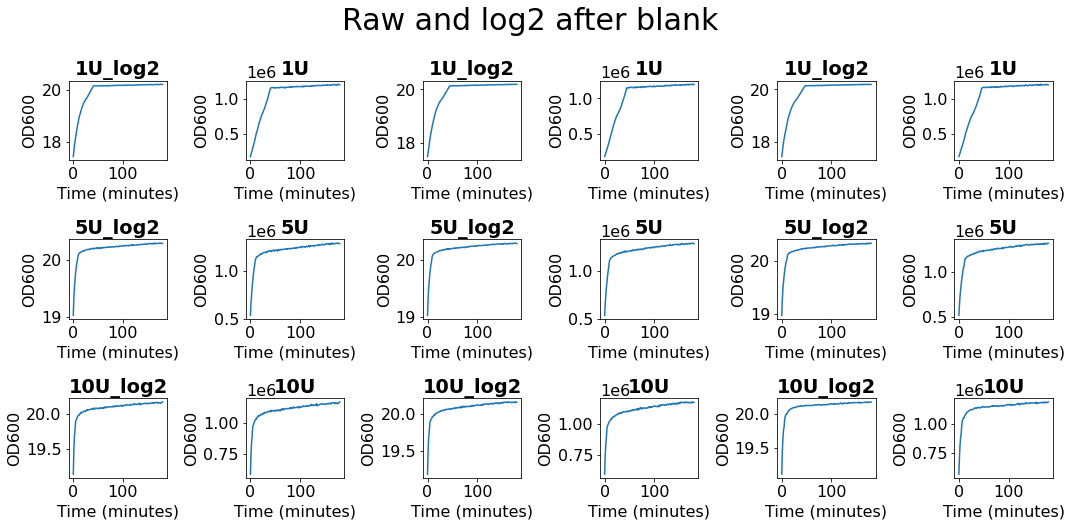

total_minutes       A100            A1       A200            A2  \
0         0.000000  17.446041  1.785590e+05  17.472397  1.818510e+05   
1         1.166667  17.670098  2.085593e+05  17.630696  2.029403e+05   
2         2.333333  17.870670  2.396667e+05  17.811730  2.300727e+05   
3         3.500000  18.041443  2.697837e+05  17.972737  2.572367e+05   
4         4.666667  18.180354  2.970517e+05  18.120049  2.848907e+05   
..             ...        ...           ...        ...           ...   
150     175.000000  20.201338  1.205615e+06  20.194080  1.199565e+06   
151     176.166667  20.204526  1.208282e+06  20.190540  1.196625e+06   
152     177.333333  20.197892  1.202739e+06  20.194146  1.199620e+06   
153     178.500000  20.195529  1.200770e+06  20.186983  1.193678e+06   
154     179.666667  20.197921  1.202763e+06  20.192411  1.198178e+06   

          A300            A3       B100            B1       B200  \
0    17.428565  1.764090e+05  19.027409  5.343440e+05  19.029867   
1    17.606624  1.995823e+05  19.336031  6.617977e+05  19.329693   
2    17.786268  2.260477e+05  19.521943  7.528187e+05  19.515734   
3    17.976299  2.578727e+05  19.656533  8.264297e+05  19.650708   
4    18.106290  2.821867e+05  19.778372  8.992557e+05  19.761747   
..         ...           ...        ...           ...        ...   
150  20.197657  1.202543e+06  20.293767  1.285383e+06  20.293687   
151  20.192746  1.198456e+06  20.297085  1.288343e+06  20.291473   
152  20.192229  1.198027e+06  20.293602  1.285236e+06  20.295924   
153  20.198310  1.203087e+06  20.290898  1.282829e+06  20.292173   
154  20.190641  1.196709e+06  20.289871  1.281916e+06  20.286660   

               B2       B300            B3       C100            C1  \
0    5.352550e+05  18.972792  5.144930e+05  19.146344  5.802617e+05   
1    6.588967e+05  19.284503  6.385777e+05  19.495669  7.392327e+05   
2    7.495857e+05  19.483705  7.331277e+05  19.682886  8.416647e+05   
3    8.230997e+05  19.606321  7.981617e+05  19.767502  8.925060e+05   
4    8.889527e+05  19.716806  8.616877e+05  19.891276  9.724577e+05   
..            ...        ...           ...        ...           ...   
150  1.285312e+06  20.325573  1.314036e+06  20.143114  1.157928e+06   
151  1.283341e+06  20.333392  1.321177e+06  20.149826  1.163328e+06   
152  1.287306e+06  20.323429  1.312084e+06  20.154261  1.166909e+06   
153  1.283963e+06  20.329514  1.317630e+06  20.156212  1.168488e+06   
154  1.279066e+06  20.332092  1.319986e+06  20.164158  1.174942e+06   

          C200            C2       C300            C3  
0    19.174971  5.918907e+05  19.104588  5.637077e+05  
1    19.505160  7.441117e+05  19.447488  7.149527e+05  
2    19.675894  8.375957e+05  19.640680  8.173987e+05  
3    19.762822  8.896150e+05  19.752738  8.834190e+05  
4    19.883845  9.674617e+05  19.806724  9.171027e+05  
..         ...           ...        ...           ...  
150  20.165057  1.175674e+06  20.170821  1.180381e+06  
151  20.167437  1.177615e+06  20.175788  1.184452e+06  
152  20.158438  1.170292e+06  20.173959  1.182951e+06  
153  20.163492  1.174399e+06  20.173814  1.182832e+06  
154  20.163287  1.174233e+06  20.180273  1.188140e+06  

[155 rows x 19 columns]

In [35]:
# add log2 values, this time no need to work with the blank columns
nsamples={}
log2tdf=pd.DataFrame()
log2tdf=pd.concat([log2tdf,workdf['total_minutes']],axis=1)
for sample in list(samples):
    if 'NC' in sample or sample in nsamples:
        continue
    # add the new sample name to the samples dictionary for easy plotting
    nsample_name=sample+'_log2'
    nsamples[nsample_name]=set()
    for well in samples[sample]:
        nwell_name=well+'00'
        nsamples[nsample_name].add(nwell_name)
        wclog2=np.log2(workdf[well].values)
        col2sample[nwell_name]=nsample_name
        # add to the table
        wclog2series=pd.Series(wclog2,name=nwell_name)
        log2tdf=pd.concat([log2tdf,wclog2series],axis=1)
        log2tdf=pd.concat([log2tdf,workdf[well]],axis=1)
# update the samples dictionary
samples.update(nsamples)

#plot the new 'plate'
plotPlate(log2tdf,'Raw and log2 after blank')  

'''# save the dataframe to a file with the sample titles
sample_names_io=['total_minutes']
for col in log2tdf.columns:
    if 'total_minutes' in col:
        continue
    sample_names_io.append(col2sample[col])
outdf=log2tdf
# change column names in output table
outdf.columns=sample_names_io
outdf.to_csv(respath+'/'+'sample_data_wlog2_'+filename+'.csv')
outdf'''
log2tdf


# Get metrics for all the sample wells curves

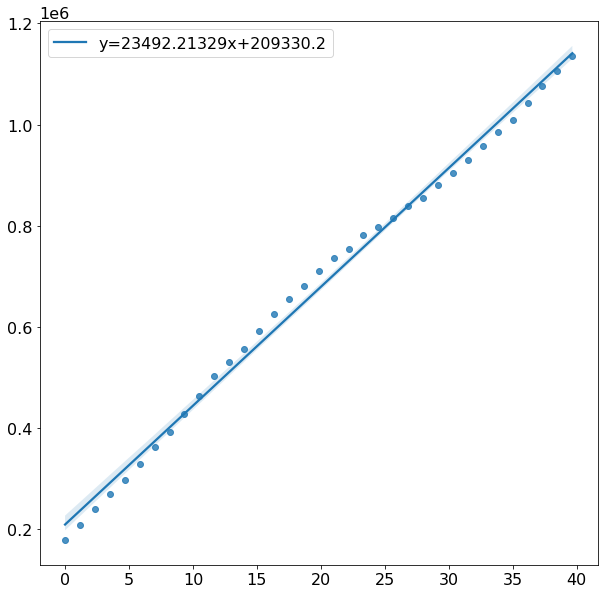

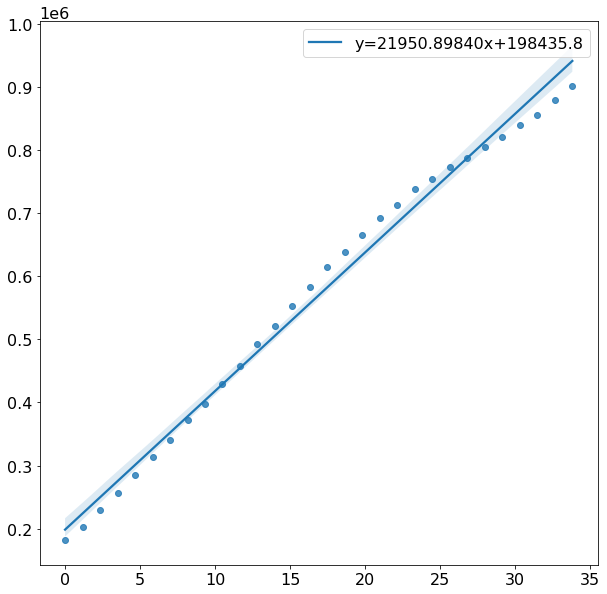

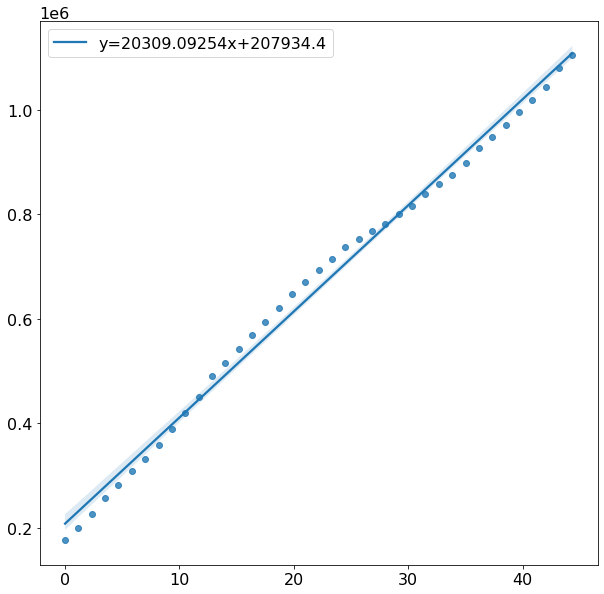

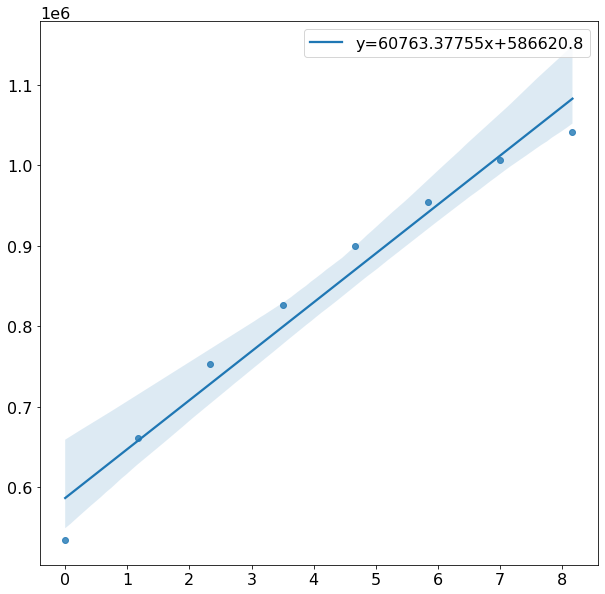

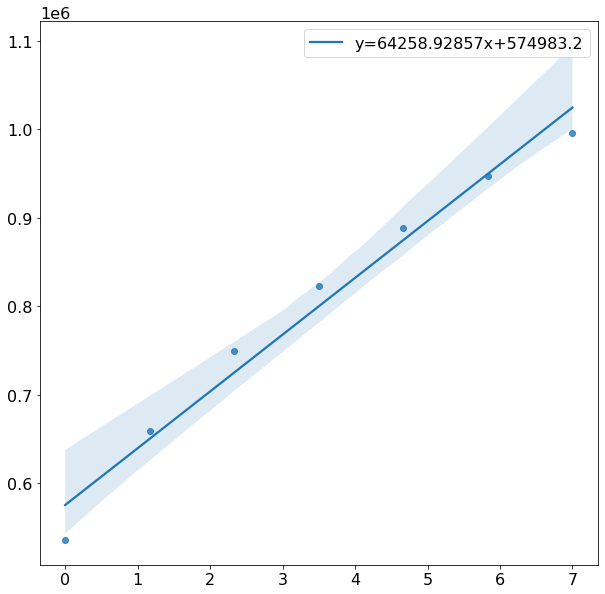

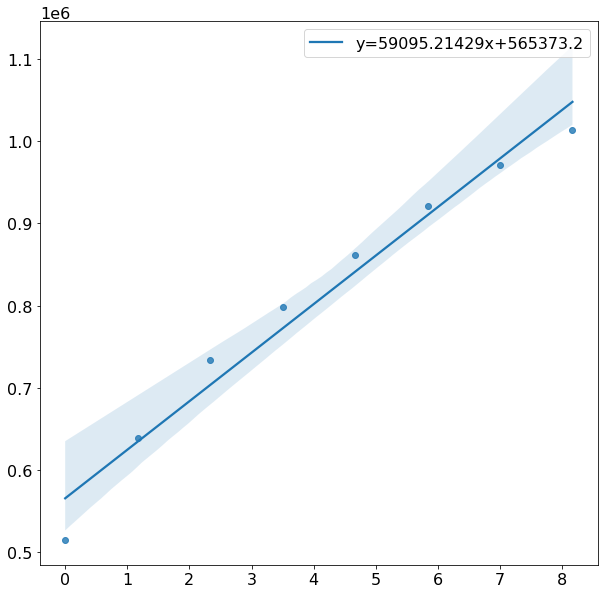

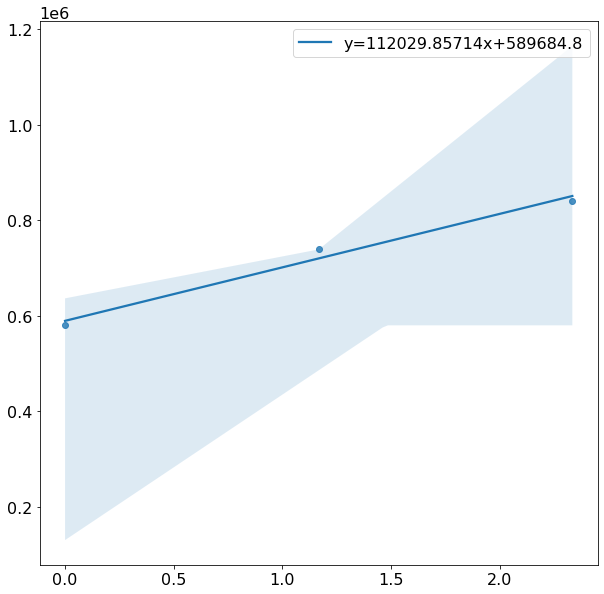

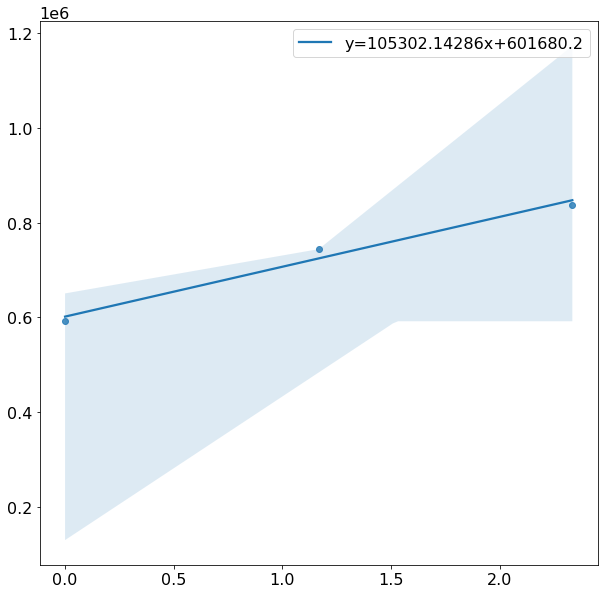

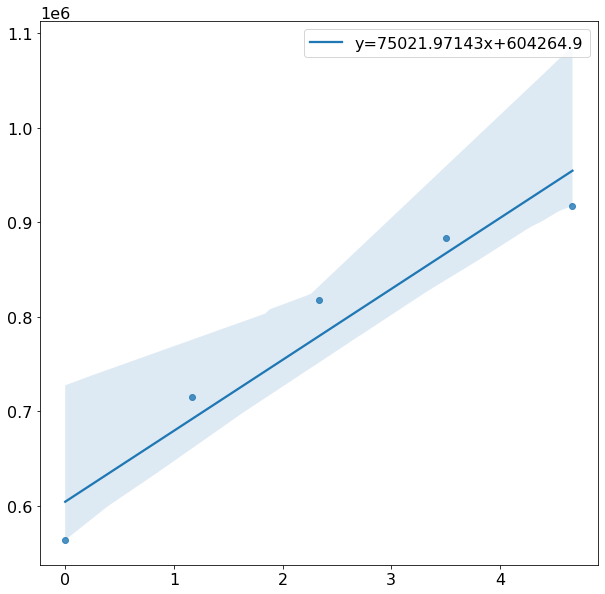

sample_name well plate_id      maxOD600    Growth_rate  Doubling_time  \
0          1U   A1  Plate 1  1.208282e+06   23492.213285       0.000043   
1          1U   A2  Plate 1  1.199620e+06   21950.898395       0.000046   
2          1U   A3  Plate 1  1.205284e+06   20309.092539       0.000049   
3          5U   B1  Plate 1  1.288417e+06   60763.377551       0.000016   
4          5U   B2  Plate 1  1.287306e+06   64258.928571       0.000016   
5          5U   B3  Plate 1  1.322500e+06   59095.214286       0.000017   
6         10U   C1  Plate 1  1.174942e+06  112029.857143       0.000009   
7         10U   C2  Plate 1  1.177646e+06  105302.142857       0.000009   
8         10U   C3  Plate 1  1.188140e+06   75021.971429       0.000013   

   Time_to_reach_maxOD600_(minutes)  Mid_log_OD600  \
0                        176.166667  710336.000000   
1                        177.333333  614468.666667   
2                        165.666667  692927.666667   
3                        165.666667  899255.666667   
4                        177.333333  823099.666667   
5                        171.500000  861687.666667   
6                        179.666667  739232.666667   
7                        161.000000  744111.666667   
8                        179.666667  817398.666667   

   Time_to_reach_mid_log_(minutes)  
0                        19.833333  
1                        17.500000  
2                        22.166667  
3                         4.666667  
4                         3.500000  
5                         4.666667  
6                         1.166667  
7                         1.166667  
8                         2.333333

In [40]:
# calculate maxOD and time to reach maxOD for the wells in log2tdf
# the final table will look like 
# well | maxOD | ttr_maxOD | mid_log OD | ttr_mid_logOD | growth_rate | doubeling_time

def getMetrics(curve1,curve2, col):
    # returns the mid-log OD and time to reach mid log
    # uses rolling regression and R values to capture different segments of the curve
    
    # rolling regression - get the R values for a regression line in every coordinate
    # curve is a list of curve values over time
    #work with the smallest window - 2 coordinates
    window=2
    slopes = []
    intercepts = []
    Rs=[]
    # get the values for the window
    for c in range(len(curve1)-window):
        ogx=curve1.loc[c:c+window]
        ogy=curve2.loc[c:c+window]
        y=np.array(ogy.values.tolist())
        x=np.array(ogx.values.tolist())
        y=y.reshape(-1,1)
        x=x.reshape(-1,1)

        lr=LinearRegression()
        lr.fit(x,y)
        R_coef=lr.score(x,y)
        if R_coef<0.95:
            '''print(col+'\t'+str(c)+' minutes')
            print(R_coef)'''
            exp=c
            break
            
        Rs.append(R_coef)
        intercepts.append(lr.intercept_)
        slopes.append(lr.coef_[0])
    ogxlist=list(curve1[0:c])
    ogylist=list(curve2[0:c])
    tslope, intercept, r_value, p_value, std_err = stats.linregress(ogxlist,ogylist)    
    # plot vs. Time
    
    plt.figure(figsize=(10,10))
    ogxlist=list(curve1[0:c])
    ogylist=list(curve2[0:c])
    tslope, intercept, r_value, p_value, std_err = stats.linregress(ogxlist,ogylist)
    g=sns.regplot(x=ogxlist,y=ogylist,line_kws={'label':"y={0:.5f}x+{1:.1f}".format(tslope,intercept)})
    #plt.yscale('log')
    #plt.xscale('log')
    plt.legend()
    plt.show()
    
    # get the metrics
    exp_phase_idx=c
    midlog_idx=int(c/2)
    growth_rate=tslope
    dbl_time=1/growth_rate
    
    
    return exp_phase_idx,midlog_idx,growth_rate,dbl_time
fpopdf=pd.DataFrame()
for col in log2tdf.columns:
    if '00' in col or 'total_minutes' in col:
        continue
    # get the values for the maxOD, midlog, growth rate and doubling time
    ep_idx,mdlg_idx,gr,dbt=getMetrics(log2tdf['total_minutes'],log2tdf[col],col)
    # use the indices to get the values from the series
    # for max OD I need to use the original columns
    ogcol=col.replace('00','')
    ogcol_list=list(log2tdf[ogcol].values)
    max_od=max(log2tdf[ogcol].values)
    # get the values for ttr_maxOD,and ttr to midlog
    ttr_max_idx=log2tdf.index[log2tdf[ogcol]==max_od].values
    ttr_max_idx=ttr_max_idx[0]
    ttr_max_od=log2tdf.loc[ttr_max_idx]['total_minutes']
    
    midlog_od=ogcol_list[mdlg_idx]
    ttr_midlog=log2tdf.loc[mdlg_idx]['total_minutes']
    
    
    # update the table
    values_to_add = { 'sample_name':col2sample[ogcol],'well': ogcol,'plate_id':plateid,'maxOD600':max_od,
                     'Growth_rate':gr,'Doubling_time':dbt,'Time_to_reach_maxOD600_(minutes)':ttr_max_od,
                     'Mid_log_OD600':midlog_od,'Time_to_reach_mid_log_(minutes)':ttr_midlog }
    row_to_add = pd.Series(values_to_add, name=ogcol)
    new_df=pd.DataFrame([row_to_add], columns=row_to_add._stat_axis)
    fpopdf = pd.concat([fpopdf,new_df],ignore_index=True)
    
fpopdf
    
    

# Plot the plate in a per metric look for column selection

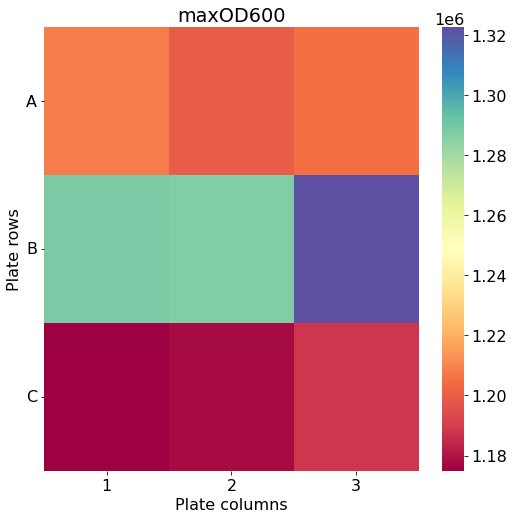

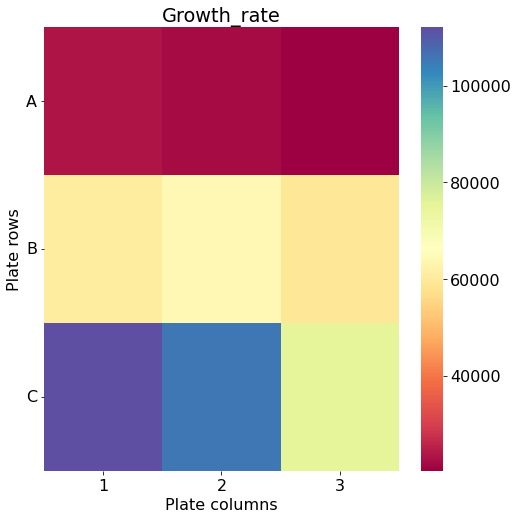

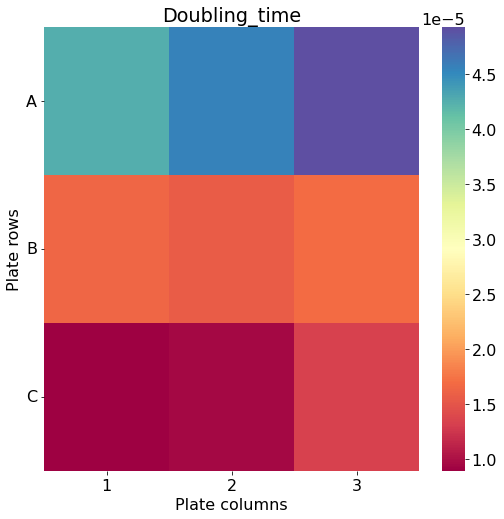

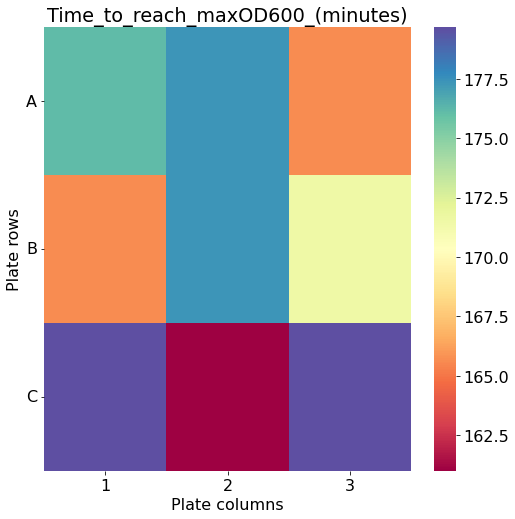

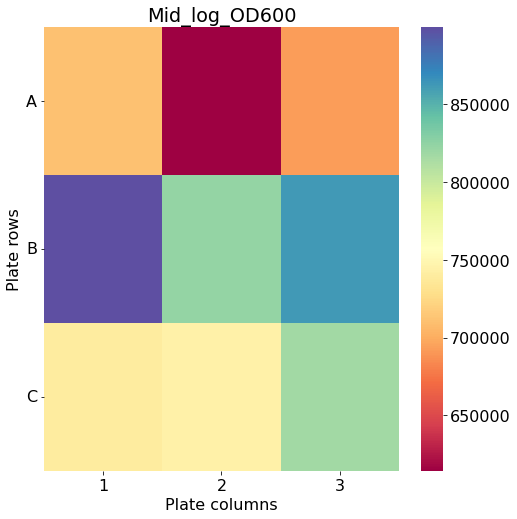

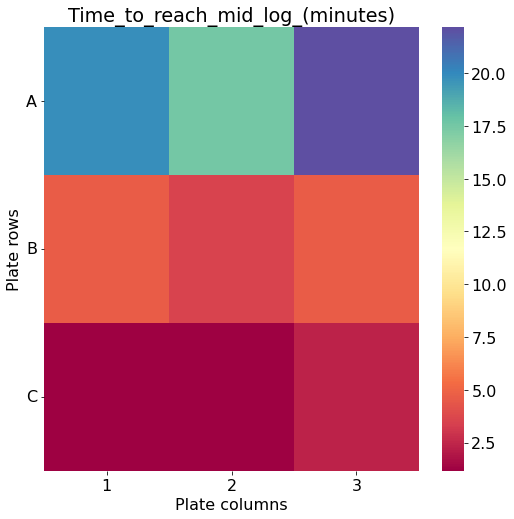

In [37]:
# plot a single metric look of the samples
def plotPlateSM(plate,metric):
    
    # plot a heatmap of the sample/well vs a metric
    # use plate columns to get the number of columns and rows for the subplots
    nrows=set()
    ncols=set()
    
    tempdict={}
    tempdf=pd.DataFrame()
    vals=[]
    letters=[]
    numbers=set()
    for col in plate['well']:
        # skip the time and temperature column
        '''if any(x in col for x in['sample_name']):
            continue'''   
        w=re.match("([A-Z])([0-9]+)",col)
        letter=w.group(1)
        nrows.add(letter)
        num=w.group(2)
        numbers.add(num)
        met_idx=plate.index[plate['well']==col].values
        met_idx=met_idx[0]
        val=plate.loc[met_idx][metric]
        if letter not in tempdict:
            tempdict[letter]=[]
        tempdict[letter].append(val)
        
    numbers=list(sorted(numbers))    
    # build the df por plotting
    tempdf=pd.DataFrame.from_dict(tempdict, orient='index',columns=numbers)
    # plot
    plt.figure(figsize=(2.5*len(numbers),2.5*len(nrows)))
    ax=sns.heatmap(tempdf, cmap='Spectral')
    ax.tick_params(axis='y', rotation=0)
    plt.title(metric)
    plt.ylabel('Plate rows')
    plt.xlabel('Plate columns')
    plt.tight_layout()
    plt.savefig(graphicspath+'/'+metric+'_'+filename +'.svg')
    plt.show()          
# plot all the metrics in the fpopdf table
for met in fpopdf.columns:
    # skip the metadata
    if any(x in met for x in ['sample_name','well','plate_id']):
        continue
    plotPlateSM(fpopdf,met)

# Select columns to remove from the table
The code will drop two columns for each choice - one for the od values and one for the log2 values

In [41]:
# select columns to remove from a dataframe - using a clean version of the data without the log2
# creating a widget for viewing the dataframe

app = JupyterDash(__name__)
# Load Data
df = cleandf
# Build App
app.layout = html.Div([
            dash_table.DataTable(
                id='table',
                columns=[
                {"name": i, "id": i, "deletable": True, "selectable": True} for i in df.columns
                ],
                data=df.to_dict('records'),
                editable=True,
                filter_action="native",
                sort_action="native",
                sort_mode="multi",
                column_selectable="multi",
                row_selectable="multi",
                row_deletable=True,
                selected_columns=[],
                selected_rows=[],
                page_action="native",
                page_current= 0,
                page_size= 10,
            ),
            html.Div(id='datatable-interactivity-container'),
            html.Button(id="save-button",n_clicks=0,children="Save"),
            html.Div(id="output-1",children="Press button to save changes")
])

@app.callback(
        Output("output-1","children"),
        [Input("save-button","n_clicks")],
        [State("table","data")]
        )

def selected_data_to_csv(nclicks,table1): 
    if nclicks == 0:
        raise PreventUpdate
    else:
        pd.DataFrame(table1).to_csv(respath+'/interim_df.csv',index=False)
        return "Data processed, continue running notebook"

# Run app and display result inline in the notebook
app.run_server(mode='inline', debug=True)



# Continue analyzing with consolidated, cleaned data

Plotting the growth curves

In [42]:
# get the updated dataframe
graphdf=pd.read_csv(respath+'/interim_df.csv')

#remove the interim file
os.remove(respath+'/interim_df.csv')
sample2col={}
# update the parameter table after deletion of columns
# now the columns are stored in the well column in the parameter table
# get the updated column list
ucol_list=list(graphdf.columns)
for cc in list(fpopdf['well']):
    if cc not in ucol_list:
        fpopdf.drop(fpopdf[fpopdf['well']==cc].index,inplace=True)
        
# create an update sample2col mapping
for cc in list(fpopdf['well']):
    dfline=fpopdf[fpopdf['well']==cc]
    sample=dfline['sample_name'].values
    sample=sample[0]
    if sample not in sample2col:
        sample2col[sample]=set()
    sample2col[sample].add(cc)
    
fpopdf
        

sample_name well plate_id      maxOD600    Growth_rate  Doubling_time  \
1          1U   A2  Plate 1  1.199620e+06   21950.898395       0.000046   
2          1U   A3  Plate 1  1.205284e+06   20309.092539       0.000049   
3          5U   B1  Plate 1  1.288417e+06   60763.377551       0.000016   
5          5U   B3  Plate 1  1.322500e+06   59095.214286       0.000017   
6         10U   C1  Plate 1  1.174942e+06  112029.857143       0.000009   
7         10U   C2  Plate 1  1.177646e+06  105302.142857       0.000009   
8         10U   C3  Plate 1  1.188140e+06   75021.971429       0.000013   

   Time_to_reach_maxOD600_(minutes)  Mid_log_OD600  \
1                        177.333333  614468.666667   
2                        165.666667  692927.666667   
3                        165.666667  899255.666667   
5                        171.500000  861687.666667   
6                        179.666667  739232.666667   
7                        161.000000  744111.666667   
8                        179.666667  817398.666667   

   Time_to_reach_mid_log_(minutes)  
1                        17.500000  
2                        22.166667  
3                         4.666667  
5                         4.666667  
6                         1.166667  
7                         1.166667  
8                         2.333333

# Consolidate curve and parameter data
Calculate the average and standard deviation of sample using the wells that are left.

155it [00:00, 3543.84it/s]


<Figure size 432x288 with 0 Axes>

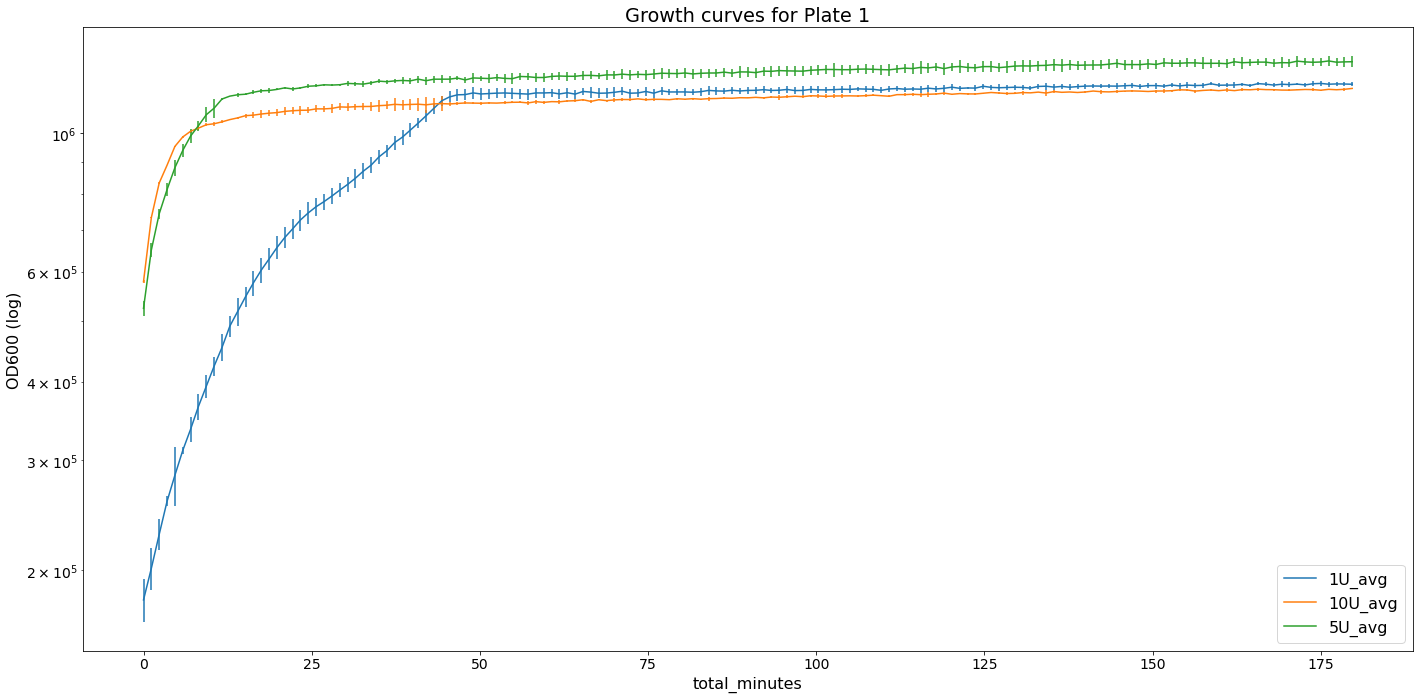

<Figure size 432x288 with 0 Axes>

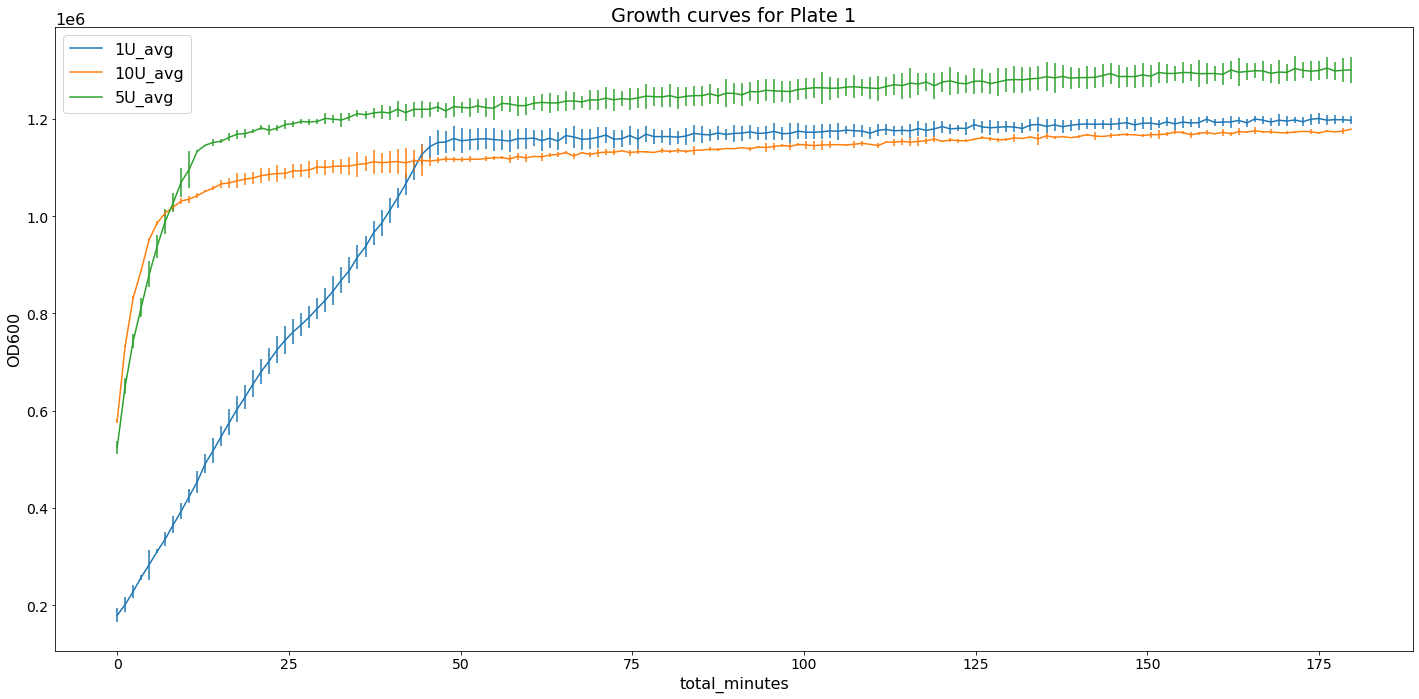

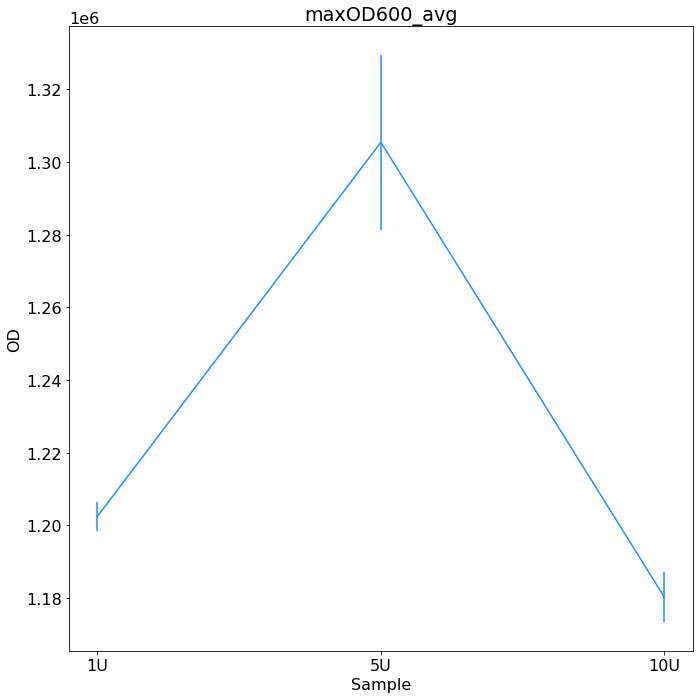

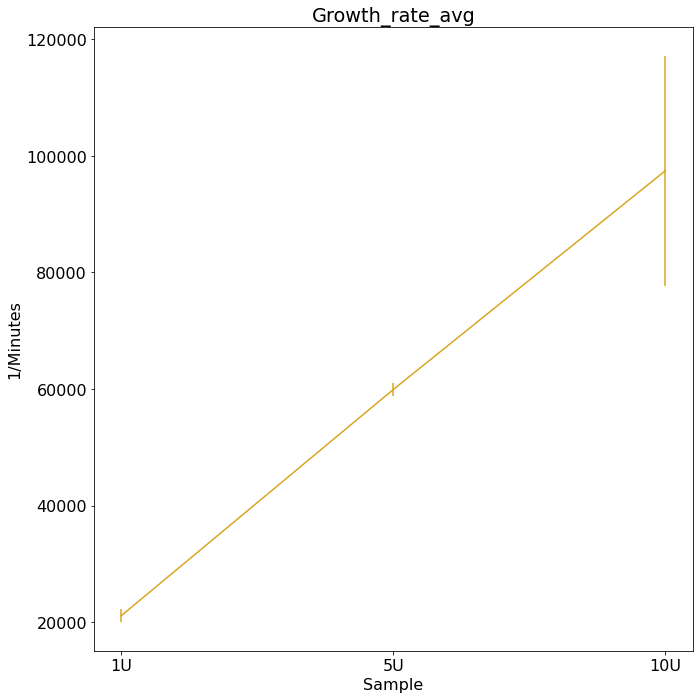

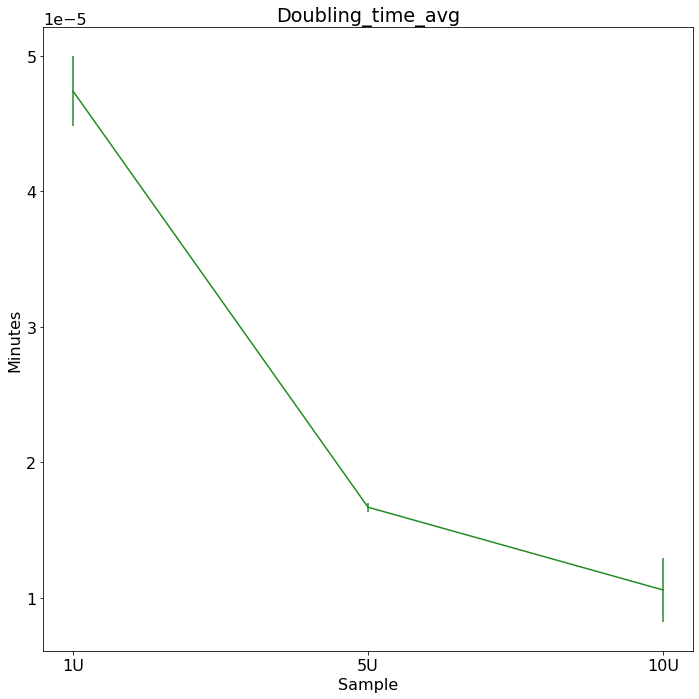

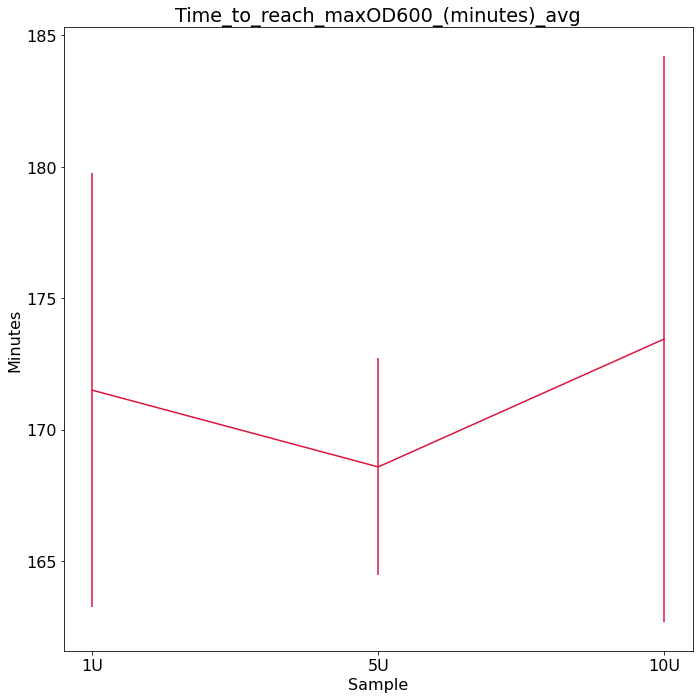

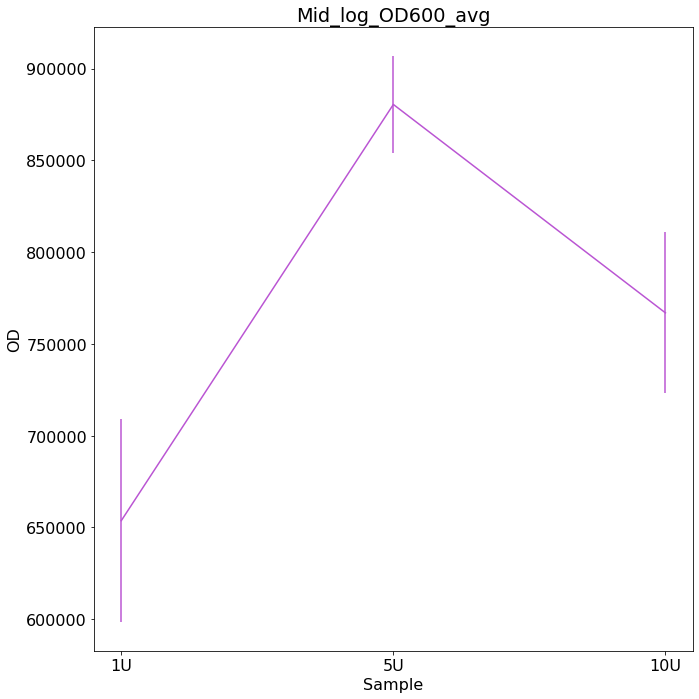

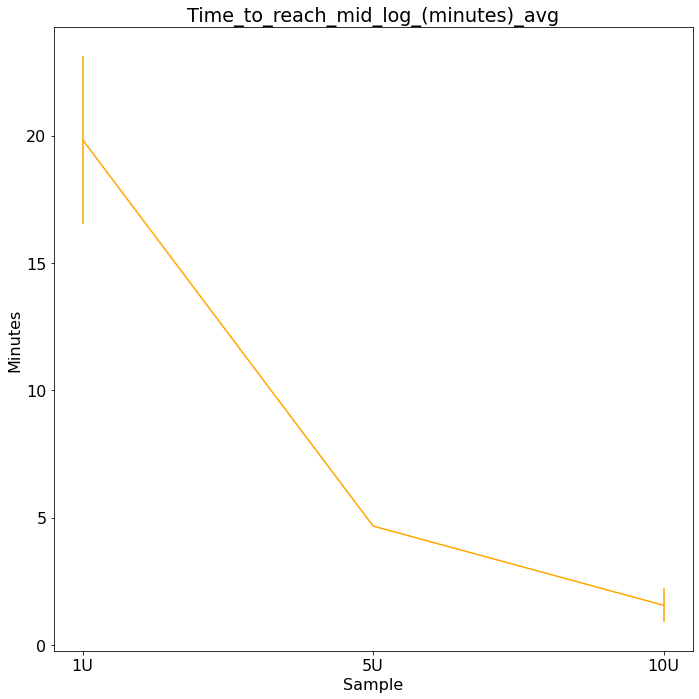

In [43]:
# start with the curves

wd={}
s_err_names=set()
s_avg_names=set()
for i, tp in tqdm(graphdf.iterrows()):
    wd[tp['total_minutes']]={}
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        vals=[]
        for well in sample2col[s]:
            vals.append(tp[well])
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = s+'_avg'
        nst_name = s+'_stdev'
        wd[tp['total_minutes']][ns_name] = s_avg
        wd[tp['total_minutes']][nst_name] = s_stdev
        s_err_names.add(nst_name)
        s_avg_names.add(ns_name)
stl=list(s_err_names)
sl=list(s_avg_names)
ngraphdf = pd.DataFrame.from_dict(wd, orient='index')
ngraphdf.index=ngraphdf.index.set_names(['total_minutes'])
ngraphdf.reset_index(inplace=True)


#plot
plt.figure()
plt.rcParams.update({'font.size': 16}) 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(20,10),
             ylabel='OD600 (log)',
             title='Growth curves for '+plateid,
             logy=True,
             fontsize=14,
             )

plt.tight_layout()
plt.savefig(graphicspath+'/growth_curves_'+filename+'.svg')
plt.show() 

# plot regular axis
#plot
plt.figure()
plt.rcParams.update({'font.size': 16}) 
ngraphdf.plot(x='total_minutes', y=sl,yerr=ngraphdf[stl].T.values, 
             figsize=(20,10),
             ylabel='OD600',
             title='Growth curves for '+plateid,
             #logy=True,
             fontsize=14,
             )

plt.tight_layout()
plt.savefig(graphicspath+'/growth_curves_regaxis_'+filename+'.svg')
plt.show() 

# now do the parameters

wpd={}
errdict={}

for col in fpopdf.columns:
    
    if any(x in col for x in ['sample_name', 'well','plate_id']):
        continue
    # now we have the parameters columns and we can go over the samples and get the values
    # calculate the average  and standard deviation per sample
    
    # samples
    for s in sample2col:
        if s not in wpd:
            wpd[s]={}
        vals=[]
        for well in sample2col[s]:
            # get the index of the well
            idx=fpopdf.index[fpopdf['well']==well].values
            idx=idx[0]
            val=fpopdf.loc[idx][col]
            vals.append(val)
        s_avg=statistics.mean(vals)
        if len(sample2col[s])<2:
            s_stdev=0
        else:
            s_stdev=statistics.stdev(vals)
        ns_name = col+'_avg'
        nst_name = col+'_stdev'
        wpd[s][ns_name] = s_avg
        wpd[s][nst_name] = s_stdev
        errdict[ns_name]=nst_name

npdf = pd.DataFrame.from_dict(wpd, orient='index')
npdf.index=npdf.index.set_names(['sample'])
npdf.reset_index(inplace=True)
mcolors=['dodgerblue','goldenrod','forestgreen','crimson','mediumorchid','orange','deepskyblue','orangered','navy','lightseagreen','deeppink']

lbdict={'maxOD600_avg': 'OD',
        'Growth_rate_avg':'1/Minutes',
        'Doubling_time_avg':'Minutes',
        'Time_to_reach_maxOD600_(minutes)_avg':'Minutes',
        'Mid_log_OD600_avg':'OD',
        'Time_to_reach_mid_log_(minutes)_avg':'Minutes'   
}

# parameter plots
for l,prm in enumerate(errdict):
    
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 16}) 
    #sns.scatterplot(x='sample',y=prm,data=npdf, color=mcolors[l])
    plt.errorbar(x=npdf['sample'], y=npdf[prm], yerr=npdf[errdict[prm]],color=mcolors[l])
    plt.title(prm)
    plt.xlabel('Sample')
    plt.ylabel(lbdict[prm])
    plt.tight_layout()
    plt.savefig(graphicspath+'/params_cons'+filename+'.svg')
    plt.show()
npdf.to_excel(respath+'/params_results_'+filename+'.xlsx')
npdf.to_csv(respath+'/params_results_'+filename+'.csv')

# Heatmap views of the data 

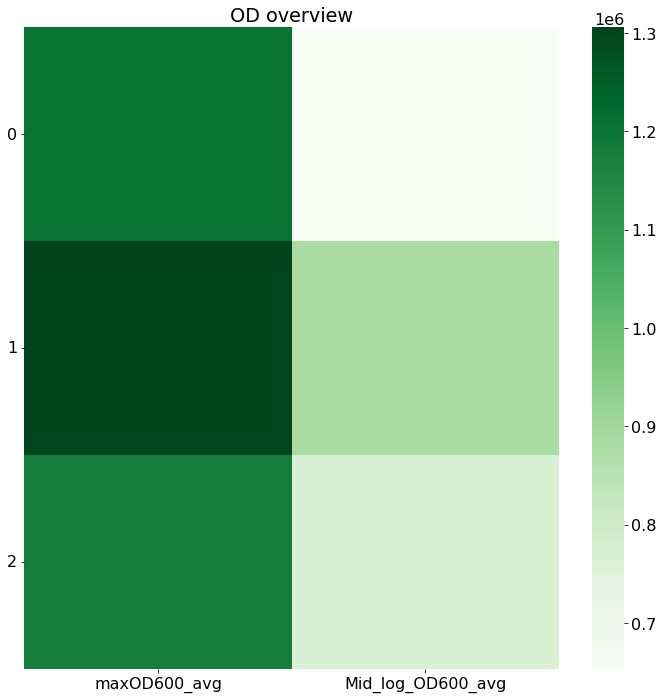

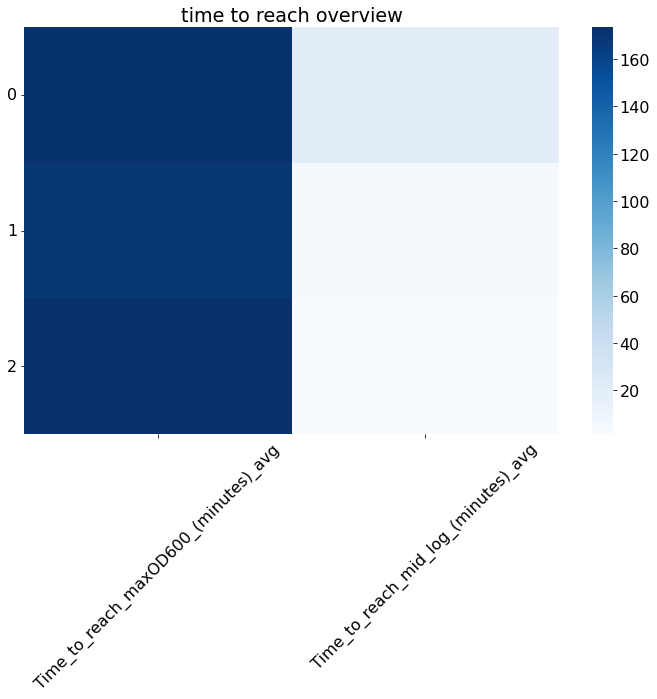

In [44]:
# max od heatmap
plotdf=npdf[['maxOD600_avg','Mid_log_OD600_avg']]
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Greens')
ax.tick_params(axis='y', rotation=0)
plt.title('OD overview')
plt.tight_layout()
plt.savefig(graphicspath+'/od_heatmap_'+filename+'.svg')
plt.show()

# time to reach
plotdf=npdf[['Time_to_reach_maxOD600_(minutes)_avg','Time_to_reach_mid_log_(minutes)_avg']]
plt.figure(figsize=(10,10))
ax=sns.heatmap(plotdf, cmap='Blues')
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='x',rotation=45)
plt.title('time to reach overview')
plt.tight_layout()
plt.savefig(graphicspath+'/ttr_heatmap_'+filename+'.svg')
plt.show()